# AirBnB Listings in Paris - Data Story and EDA

Paris is a city of love, or at least it is one like this for me as my own love story started there... <3 

Thousands of people from all over the world are traveling to France's capital each year. Some come experience outstanding french cusine, some are diving deep into history, art and architecture, others just arrive "to see Paris and die". Whatever the reason is behind the visit, all this people need places to stay. Among traditional hotels, family and friends stays there is a new popular way of finding accommodation: to rent a place through AirBnB. Therefore I am taking a deeper look at the data related to AirBnB listings in Paris.

When thinking about listings the first question that comes to mind is "What takes the place to get booked?". It would have been natuaral to look at historical renting data and compare it with characteristics of the listings. Unfortunately AirBnB does not reveal past booking information. Instead I am working with data downloaded from http://insideairbnb.com/get-the-data.html that includes the following datasets:
 - listings with informations about each place listed on 06/05/2019 (scrap date)
 - reviews with information about past reviews
 - calendar data indicating listing availability for a year from scrap date.
 
All of the datasets are too large to upload to github, but similar ones can be uploaded from above site that periodically scraps for more recent data. All datasets were cleaned by me prior (please see Data Cleaning folder for details). 
 
First I am importing necessary packages.

In [1]:
# import relevant packages
import pandas as pd
import numpy as np

#packages to work with maps
import geopandas
import folium
from shapely.geometry import Point

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# read review data from a zipped file to a dataframe
rev = pd.read_csv('reviews_cleaned.csv.gz', compression='gzip', header=0, 
                  parse_dates = ['date'], sep=',', quotechar='"', error_bad_lines=False, low_memory=False)
rev.drop('Unnamed: 0', axis = 1, inplace=True)

The first loaded dataset contains information about past reviews. According to Inside AirBnB disclaimer, this information can be used to estimate past occupancy rate and as well as income that the host earned. 

So called "San Francisco model" is used for this purpose. It uses review rate of 50% (meaning each second guest leaves a review) to convert reviews to estimated bookings and average length of stay calculated by AirBnB for each city. In case of Paris it equals to 5.2 nights. 

Occupancy rate and income are then calculated by below formulas:

**Occupancy rate = Average Length of Stay * Reviews per Month / Review Rate**

**Income = Occupancy Rate * Price * 12**

First I will calculate reviews per month for the year 2018. Occupancy rate is proportional to average reviews per month, therefore it is okay to use number of reviews per month to analyze data. 

The data was scrapped on 06/05/2019 and therefore 2018 is the closest full year available.

In [3]:
# filter for reviews in 2018
rev_2018 = rev[rev.date.dt.year == 2018].loc[:, ['listing_id', 'id', 'date']]
rev_2018['month'] = rev_2018.date.dt.month
rev_2018.columns = ['id', 'count', 'date', 'month']

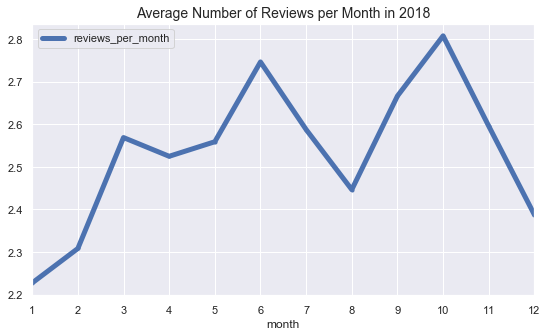

In [4]:
# count the number of reviews per month for each listing 
a = rev_2018.groupby(['id', 'month']).count()
a.drop('date', axis = 1, inplace = True)
a.reset_index(inplace = True)

# calculate average reviews per each month 
a = a.groupby('month').mean()
a.drop('id', axis = 1, inplace = True)
a.rename({'count':'reviews_per_month'}, inplace = True, axis = 1)


# plot the results
a.plot(figsize=[9,5], style = '.-', lw = 5)
plt.title('Average Number of Reviews per Month in 2018', size = 14)
plt.xticks(np.arange(1,13,1))
plt.show()

The above graph can be used to draw conclusions about demand (past bookings) for each month in 2018. It shows that the busiest months are June and October. On contrast, winter represents a slow season and also there is a demand drop in August. This indicates that people don't like travelling to a city full of sightseeing in cold months. And during summer (as demand drops from June to August) tourist may choose seaside vacations instead.

Let's see if similar pattern exists for other years. I will first define a functions that returns average number of reviews per month for a certain year and then will apply it to create a dataframe for years 2010 to 2018.

In [5]:
# define a function that returns average number of reviews per month in a provided year
def rev_per_month(year, df):
    """Calculate average number of reviews for each month in a given year"""
    x = df[df.date.dt.year == year].loc[:, ['listing_id', 'id', 'date']]
    x['month'] = x.date.dt.month
    x.columns = ['id', 'count', 'date', 'month']
    x = x.groupby(['id', 'month']).count()
    x.drop('date', axis = 1, inplace = True)
    x.reset_index(inplace = True)
    x = x.groupby('month').mean()
    x.drop('id', axis = 1, inplace = True)
    x.sort_index()
    return x

In [6]:
# apply above function to create a dataframe for the years 2010 through 2018
all_avg_rev = rev_per_month(2010, rev)
all_avg_rev.rename(columns = {'count': '2010'}, inplace = True)
for year in np.arange(2011, 2019, 1):
    all_avg_rev[str(year)] = rev_per_month(year, rev).values
all_avg_rev.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']    

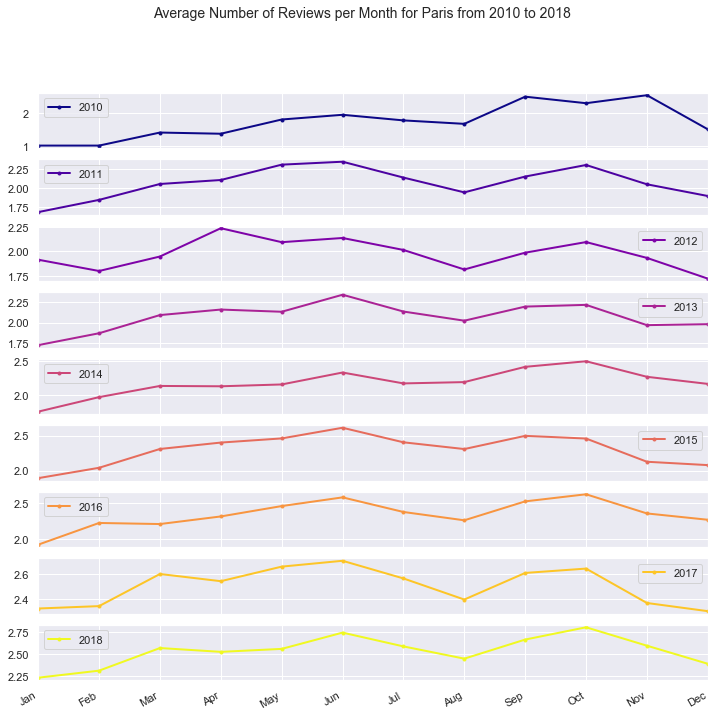

In [7]:
# plot the data to show bookings patterns
sns.set_style('darkgrid')
all_avg_rev.plot(figsize = [12,12], style = '.-', colormap = 'plasma', subplots = True, lw = 2)
plt.suptitle('Average Number of Reviews per Month for Paris from 2010 to 2018', size = 14)
plt.xticks(np.arange(12), all_avg_rev.index)
plt.show()

Almost all years (the earlier data for 2010 and 2011 is slightly different to the possible facts of fewer listings available in general and less people reviewing anything back then) show similar pattern:
 - demand is the lowest in the winter
 - people seem to travel to Paris most during spring and fall
 - demand drops throughout the summer reaching minimum in August as tourists in general prefer being in the nature than sightseeing during hot months
 
Listings on AirBnB are primerily offered by private hosts that are renting their own places when they travel themselves. It is interesting to see if the supply corresponds to the demand and when most listings are being offered.
 
For this purpose, I will use calendar dataset that contains availability information for the full year from the scrap date. In this case, from 06/06/2019 to 06/05/2020. 

In [8]:
# read data from a zipped file to a dataframe
cal = pd.read_csv('calendar_cleaned.csv.gz', compression='gzip', header=0, parse_dates = ['date'], 
                  sep=',', quotechar='"', error_bad_lines=False, low_memory=False)
cal.drop('Unnamed: 0', axis = 1, inplace = True)

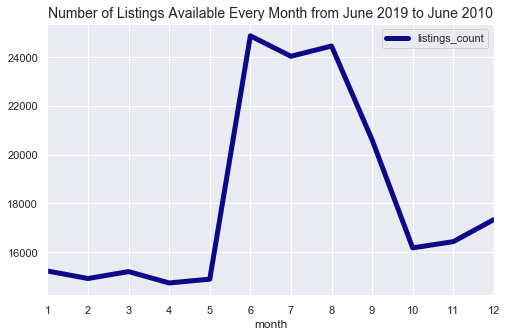

In [9]:
# filter for available listings
av = cal[cal.available == 't'].loc[:, ['date', 'listing_id']]

# count number of days each listing is available in each month
av.loc[:,'month'] = av.date.dt.month
av = av.groupby(['month', 'listing_id']).count()
av.columns = ['listings_count']

# count how many listings are available each month
av.reset_index()
av = av.groupby('month').count()

# plot number of available listings for upcoming year
sns.set_style('darkgrid')
av.plot(colormap = 'plasma', lw = 5, figsize = [8,5])
plt.title('Number of Listings Available Every Month from June 2019 to June 2010', size = 14)
plt.xticks(np.arange(1,13,1))
plt.show()

Interestingly supply is not fully correlated with demand with most listings offered during summer months. It supports the fact that hosts usually list their primary residences and do so when they travel themselves. Summer is the most popular time for travels therefore the supply is high. Winter and early spring offers the least amount of available places. 

Also there is a slight increase in supply during winter holidays that can also be explained by host travelling to see the family during those times.

Will the price of offered listings be more in line with the demand?

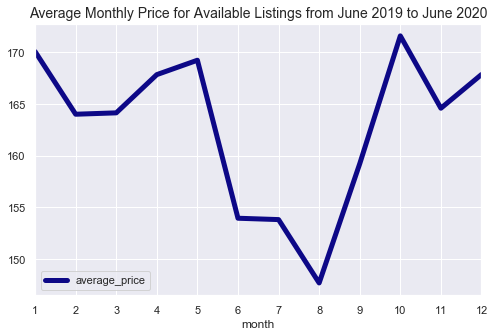

In [10]:
# filter for available listings and calculate average monthly price of available listings
av_pr = cal[cal.available == 't'].loc[:,['date', 'price', 'listing_id']]
av_pr['month'] = av_pr.date.dt.month
av_pr.drop('date', axis =1, inplace = True)
av_pr = av_pr.groupby(['month', 'listing_id']).mean()
av_pr.columns = ['average_price']
av_pr = av_pr.groupby('month').mean()

# plot the results
sns.set_style('darkgrid')
av_pr.plot(colormap = 'plasma', lw = 5, figsize = [8,5])
plt.title('Average Monthly Price for Available Listings from June 2019 to June 2020', size = 14)
plt.xticks(np.arange(1,13,1))
plt.legend(loc = 'lower left')
plt.show()

Average price is definitely correlated with the demand with high picks in late spring and early fall and big dive in August. Lower price during summer can also be explained by more listings offered during that time. 

Now let's take a closer look at the listings themselves and see what is being offered.

In [11]:
# load listing dataset
df = pd.read_csv('listings_cleaned.csv', header = 0, parse_dates = ['host_since', 'first_review', 'last_review'])
df.drop('Unnamed: 0', axis = 1, inplace = True)

All listings are divided into three groups. Depending on the room type they fall into: Entire home, Private room and Shared room. The first category represent the places that are being rented entirely without the host on premises so that the tourists have more privacy. Private and shared room mean sharing either common spaces in the house or the room itself.

It definitely makes sense to explore this categories separately as they offer different experiences. But first let's take a look how are the listings distributed between these types.

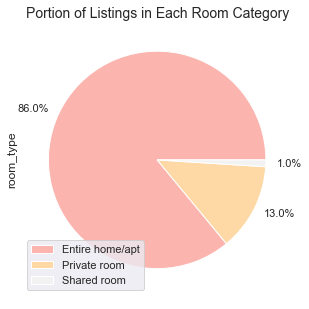

In [12]:
# count % of listings in each category
x = (df.room_type.value_counts(normalize = True)*100).round(0)

# display the outcome in pie chart
x.plot(kind = 'pie', colormap = 'Pastel1', labels = (x.astype(str) + '%'), figsize = [5,5])
plt.title('Portion of Listings in Each Room Category', size = 14)
plt.legend(x.index, loc = 'lower left', frameon = True)
plt.show()

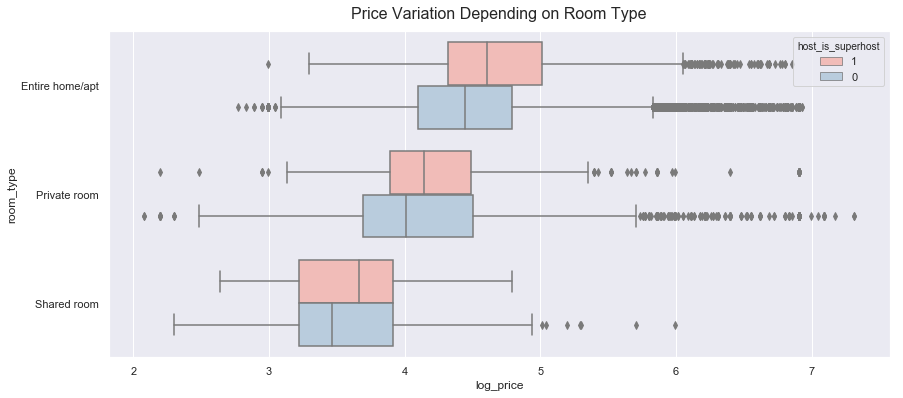

In [13]:
# check price distribution among room types
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,1,figsize = [14,6])
sns.boxplot(x = 'log_price', y = 'room_type', data = df, palette = 'Pastel1', 
            hue = 'host_is_superhost', hue_order = [1,0], ax = ax)
plt.title('Price Variation Depending on Room Type', size = 16, y = 1.02)
plt.show()

Entire home listings represent 86% of all listings. This supports the idea that privacy is important for travelers and they tend to stay in entire residences without needing to share any place with strangers. As entire apartments offer a different level of experience (more privacy and often more space), there prices are aslo higher in general. 

Interestingly, however, the most expensive listings are in Private room category for non-superhosts. These can be some luxury suits or boutique hotels that offer unique experiencies.

It will also be interesting to see where each of these listing is located. To achieve this I will use the .geojson file containing geografical data on Paris neighbourhoods. I am using geopandas to read it. After plotting the map I will add dots corresponding to listing locations (using latitude and longitude) colored according to their room types with sizes corresponding to prices.

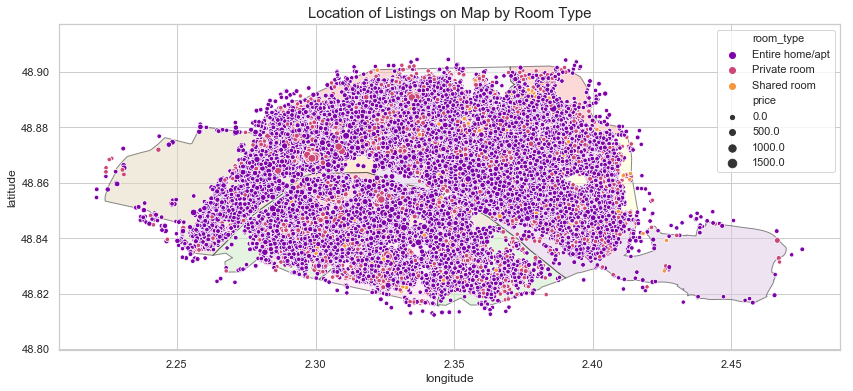

In [14]:
#plot locations of all listings in each category on map

#load file with Paris neighbourhoods
n_df = geopandas.read_file("neighbourhoods (1).geojson")

#set plot style and size
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (14,6))

#plot listings over the neighbourhoods with color codes for room types and sizes for prices
n_df.plot(alpha=0.5, edgecolor='k', cmap = 'Pastel1', ax = ax)
sns.scatterplot(x = 'longitude', y = 'latitude', palette = 'plasma', hue = 'room_type', size = 'price', 
                data = df, ax = ax)
plt.title('Location of Listings on Map by Room Type', size = 15, y =1.02)

plt.axis('equal')
plt.show()

The map above is very clattered as there are over 60,000 listings. However, it shows that entire home listings represent majority of the places in each neighbourhood. Also it can be seen that private rooms with really high prices are located close to main Paris attractions like The Eiffel Tower (the views from these places must be breathtaking) and Louvre.

Let's create a nicer representation and use actual map (using folium package for this). To have a cleaner result I will randomly select 1000 listings and add their locations similar way like done above (with different colors for each room category and sizes correlated with prices). Also this map will be interactive (possible to zoom in and out and by clicking on each dot to get information about the listing).

In [16]:
# load Paris map using coordinates
m = folium.Map(location=[48.86, 2.35], zoom_start=12)
 
# add neighbourhoods outline
folium.Choropleth(
 geo_data="neighbourhoods (1).geojson",
 fill_color='lightpink',
 fill_opacity=0.4
).add_to(m)

# sample for 1000 listings
x = df.sample(1000)

# assign color for each room type
colors = {'Entire home/apt': 'blue', 'Private room': 'red', 'Shared room': 'green'}

# add points with cooresponding colors, sizes and popup note to the map
for r_type in ['Entire home/apt', 'Private room', 'Shared room']:
    y = x[x.room_type == r_type].loc[:, ['longitude', 'latitude', 'price']].sort_values('price',ascending = False)
    for i, row in y.iterrows():
        folium.Circle(location = [row['latitude'], row['longitude']], radius = row['price']/5, 
                      popup = r_type + ' price: $'+str(row['price']),
                  color =colors[r_type], fill = True, fill_color = colors[r_type], fill_opacity = 0.8).add_to(m)

# add markers for Paris main attractions 
attractions = pd.DataFrame.from_dict({'1':[48.858093, 2.294694, 'Eiffel Tower'], 
                           '2':[48.86111, 2.33639, 'Louvre'],
                           '3':[48.852966, 2.349902, 'Notre Dame'],
                           '4': [48.873756, 2.294946, 'Arc de Triumphe'],
                           '5': [48.886452, 2.343121, 'Sacre Coeur']}, orient = 'index',
                                    columns = ['latitude', 'longitude', 'name'])

for i, row in attractions.iterrows():
    folium.Marker(location = [row['latitude'], row['longitude']], popup = row['name']).add_to(m)        
        
# ensure all plotted elements are visible        
m.fit_bounds(m.get_bounds())

# save the map for future references
m.save('listing_distribution.html')

#display the map
m

As the majority listings in each neighbourhood are entire home ones, will only look at them in further analysis.

In [17]:
# filter for Entire home/apt listings
df_home = df[df.room_type == 'Entire home/apt'].loc[:,['id', 'price']]

df_home.columns = ['listing_id', 'price']

# merge with reviews to have only the ones for Entire home/apt listings
rev_home = df_home.merge(rev.loc[:,['id','date', 'listing_id', 'reviewer_name', 'reviewer_id', 'canceled_res']], 
                         on = 'listing_id')

Now will perform similar computations that were done for all reviews:

1. compute average number of reviews per each month and year
2. plot to see the trend
3. check if future availability and pricing is in line with the previous demand

In [18]:
# build a dataframe containing monthly average number of reviews for each year
home_avg_rev = rev_per_month(2010, rev_home)
home_avg_rev.rename(columns = {'count': '2010'}, inplace = True)

for year in np.arange(2011, 2019, 1):
    home_avg_rev[str(year)] = rev_per_month(year, rev_home).values
home_avg_rev.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']    

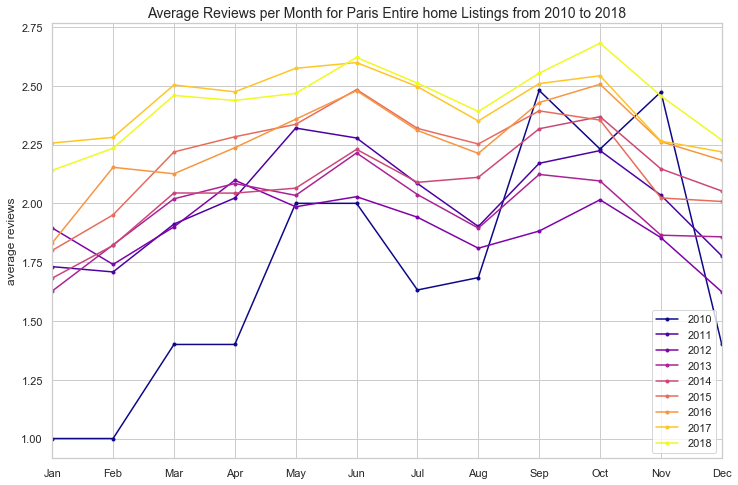

In [19]:
# plot all years on one grid
home_avg_rev.plot(figsize = [12,8], style = '.-', colormap = 'plasma')
plt.title('Average Reviews per Month for Paris Entire home Listings from 2010 to 2018', size = 14)
plt.ylabel('average reviews')
plt.xticks(np.arange(12), all_avg_rev.index)
plt.legend(loc = 'lower right')
plt.show()

This time I have plotted all years on the same graph. This helps to see that the average number of reviews increases with the time, which means that more and more visitors are using AirBnB for their stays in Paris. 

Interestingly to see that years can be divided into pairs (2018-2017, 2016-2015 and so on going backwards) that share similar behavior and represent similar values.

In [20]:
# merge Entire home/apt listings with calendar info of available listings for the next year
cal_home = df_home.merge(cal.loc[:,['listing_id', 'date', 'available']], on = 'listing_id')

In [21]:
# calculate number of listings available each month for the next 12 months
av_home = cal_home[cal_home.available == 't'].loc[:, ['date','price', 'listing_id']]
av_home.loc[:,'month'] = av_home.date.dt.month
av_home = av_home.groupby(['month', 'listing_id']).count()
av_home.drop('date', axis=1, inplace=True)
av_home.columns = ['listings_count']
av_home = av_home.reset_index()

# count how many listings are available each month
av_home = av_home.groupby('month').count()

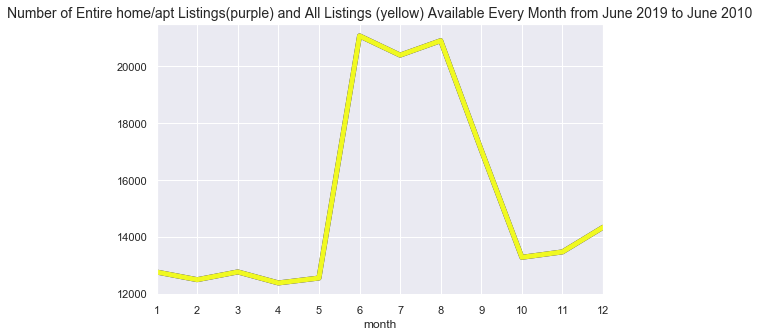

In [22]:
# plot the data against the data for all listings
sns.set_style('darkgrid')
ax = av_home.listings_count.plot(colormap = 'plasma', lw = 5, figsize = [8,5])
av_home.listings_count.plot(colormap = 'plasma_r', lw = 5, ax = ax)
plt.title('Number of Entire home/apt Listings(purple) and All Listings (yellow) Available Every Month from June 2019 to June 2010', size = 14)
plt.xticks(np.arange(1,13,1))
plt.show()

In [23]:
# calculate average price for each month 
av_pr_home = cal_home[cal_home.available == 't'].loc[:,['date', 'price', 'listing_id']]
av_pr_home['month'] = av_pr_home.date.dt.month
av_pr_home.drop('date', axis =1, inplace = True)
av_pr_home = av_pr_home.groupby(['month', 'listing_id']).mean()
av_pr_home.columns = ['average_price_ent_home']
av_pr_home = av_pr_home.groupby('month').mean()

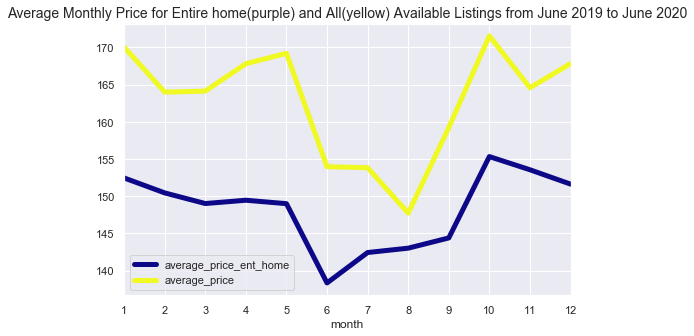

In [24]:
# plot the results against data for all listings
sns.set_style('darkgrid')
ax = av_pr_home.plot(colormap = 'plasma', lw = 5, figsize = [8,5])
av_pr.plot(colormap = 'plasma_r', lw = 5, ax = ax)
plt.title('Average Monthly Price for Entire home(purple) and All(yellow) Available Listings from June 2019 to June 2020', size = 14)
plt.xticks(np.arange(1,13,1))
plt.legend(loc = 'lower left')
plt.show()

The number of listings available each month is identical for all listings and exclusively for entire home/apt ones. This can be explained by vast majority of available listings (86% of all).

The graphs for avearage prices look a lot differently. The average monthly prices for all listings are higher than those for entire home listings. This can be due to the presence of luxury suits or boutique hotel rooms offered as private rooms. 

Also the general trend is different. The best prices for entire home listins are offered in June vs. August for all listings.
However, the average price is in line with previous demand with higher prices in busier seasons (late spring and fall).

Using previously described "San Francisco' model, I will calculate occupancy rate and yearly estimated income:

1. formula for occupancy rate:

Occupancy Rate = Average Stay * Average Number of Revies per Month / Review rate

2. formula for estimated income:

Estimated Income = Occupancy Rate * Price per Night * 12

In [25]:
# calculate occupancy rate and estimated income
avg_stay_paris = 5.2
review_rate = 0.5
rev_home_2018 = rev_home[rev_home.date.dt.year == 2018].loc[:, ['listing_id', 'price', 'id']]
rev_home_2018 = rev_home_2018.groupby(['listing_id', 'price']).count().loc[:,['id']]/12
rev_home_2018.reset_index(inplace = True)
rev_home_2018.rename({'id': 'reviews_per_month'}, axis = 1, inplace = True)

# add columns for occupancy rate and income
rev_home_2018['occupancy_rate'] = avg_stay_paris * rev_home_2018['reviews_per_month'] / review_rate
rev_home_2018['income'] = rev_home_2018.occupancy_rate * rev_home_2018.price *12

# occupancy rate over 100 is impossible, therefore will drop those values
rev_home_2018.drop(rev_home_2018[rev_home_2018.occupancy_rate > 100].index, inplace = True)

In [26]:
# check occupancy rate information
rev_home_2018.occupancy_rate.describe()

count    25991.000000
mean        10.341880
std         12.027279
min          0.866667
25%          2.600000
50%          6.066667
75%         13.866667
max         99.666667
Name: occupancy_rate, dtype: float64

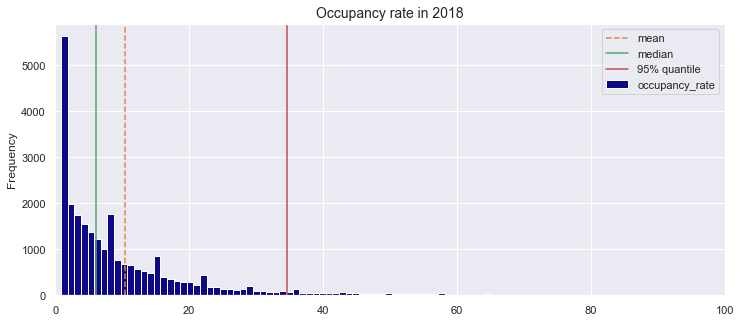

In [27]:
# plot histogram distribution of occupancy rate with vertical lines for mean, medium and 95% quantile
rev_home_2018.occupancy_rate.plot(kind = 'hist', bins = 100, colormap = 'plasma', figsize = [12,5])

plt.axvline(rev_home_2018.occupancy_rate.mean(), color = 'C1', linestyle = '--', label = 'mean')
plt.axvline(rev_home_2018.occupancy_rate.median(), color = 'C2', label = 'median')
plt.axvline(rev_home_2018.occupancy_rate.quantile(0.95), color = 'C3', label = '95% quantile')

plt.legend(frameon = True)
plt.xlim(0,100)
plt.title('Occupancy rate in 2018', size = 14)

plt.show()

In [28]:
# check income information
rev_home_2018.income.describe()

count     25991.000000
mean      14399.279966
std       22301.151961
min         187.200000
25%        2600.000000
50%        6864.000000
75%       17160.000000
max      416000.000000
Name: income, dtype: float64

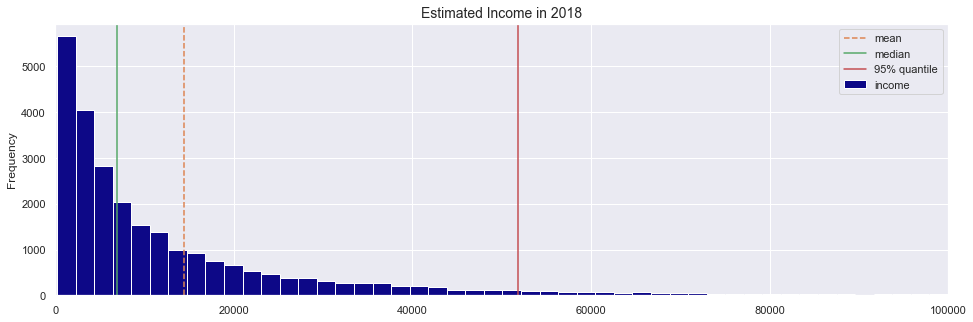

In [29]:
# plot income histogram with vertical lines for mean, median and 95% quantile
rev_home_2018.income.plot(kind = 'hist', bins = 200, colormap = 'plasma', figsize = [16,5])

plt.axvline(rev_home_2018.income.mean(), color = 'C1', linestyle = '--', label = 'mean')
plt.axvline(rev_home_2018.income.median(), color = 'C2', label = 'median')
plt.axvline(rev_home_2018.income.quantile(0.95), color = 'C3', label = '95% quantile')

plt.legend(frameon = True)
plt.xlim(0,100000)
plt.title('Estimated Income in 2018', size = 14)

plt.show()

The above findings and graphs support the idea that most apartments listed on AirBnB are private residences rented to tourists when hosts are traveling themselves. Thus half of the listings have occupancy rate of 6% or less, which corresponds to approximately 22 calendar days. Average occupanccy rate is higher and is slightly over 10% (36 calendar days). Also 95% of listings don't exceed the rate of 35% (about 128 calendar days ~ third of the year).

Income distribution is also highly skewed with half of the listing generating under $ 7,000 yearly income in 2018. Average income is about $14,000 and 95% listings did not make over $55,000. The maximum income is over $400,000 though and it will be interesting to take a look at the listings that generated high income.

Before we check what listings have really high occupancy and generated excessive income, let's take a look at relationship between income and occupancy rate. As price is another variable income depends on, I will add it to the equation as well.

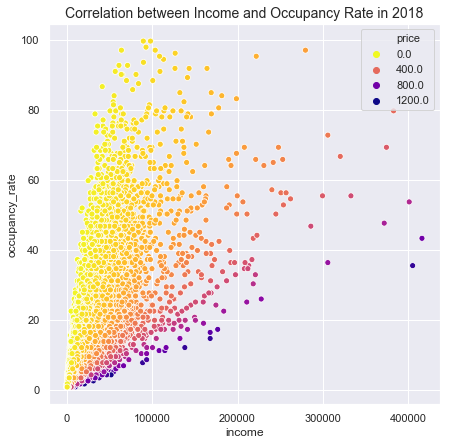

In [30]:
# build scatter plot with colors corresponding to prices
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
sns.scatterplot(data = rev_home_2018, x = 'income', y = 'occupancy_rate', hue = 'price',
                palette = 'plasma_r')
plt.title('Correlation between Income and Occupancy Rate in 2018', size = 14)
plt.show()

The above graph shows that while income and occupancy rate are highly correlated, the listings that generated the most income were not the ones with the highest occupancy rate. The price level of listings was high for high income places. Also we can see that some listings with really high occupancy rates did generate high income, but for most of them prices were on the lower side. 

Let's now dive deeper in analysis and see what listings had high occupancy rates and which ones generated high income. At the same time I will explore what factors may influence these parameters.

For these purposes I will merge our dataframe with income and occupancy rate with data for each listing.

In [31]:
# select certain columns for Entire home/apt listings
x = df[df.room_type == 'Entire home/apt'].loc[:, ['id', 'host_id', 'host_since', 'host_response_time', 
                                                'host_response_rate', 'host_is_superhost', 'host_verifications',
                                                'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 
                                                'accommodates', 'bathrooms', 'bedrooms', 'beds',
                                                'amenities', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
                                                'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 
                                                'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                                'review_scores_checkin', 'review_scores_communication',
                                                'review_scores_location', 'review_scores_value', 'instant_bookable',
                                                'cancellation_policy', 'calculated_host_listings_count',
                                                'reviews_per_month', 'is_host_near', 'amenities_count'
                                                 ]]
# rename columns for analysis and merge ease
x.rename({'neighbourhood_cleansed': 'neighbourhood', 'calculated_host_listings_count':'total_listings_per_host', 
          'reviews_per_month':'reviews_per_month_total'}, axis =1, inplace = True)

rev_ent = rev_home_2018.rename({'reviews_per_month':'reviews_per_month_2018', 'listing_id':'id'}, axis = 1)

# merge two datasets
ent_home = x.merge(rev_ent, on = 'id')

# change values in cancellation policy coulmns to three values
ent_home.cancellation_policy.replace({'strict_14_with_grace_period':'strict', 'super_strict_60':'strict', 
                                      'super_strict_30':'strict'}, inplace = True)
# round review scores to a whole numbers
for x in ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                                'review_scores_checkin', 'review_scores_communication',
                                                'review_scores_location', 'review_scores_value']:
    ent_home[x] = ent_home[x].astype(int)

Let's see first in which neighbourhoods the most profitable and the most rented places are located. For this purpose I will build a bar plot showing average meanings for each variable by neighbourhood sorted in descending order.

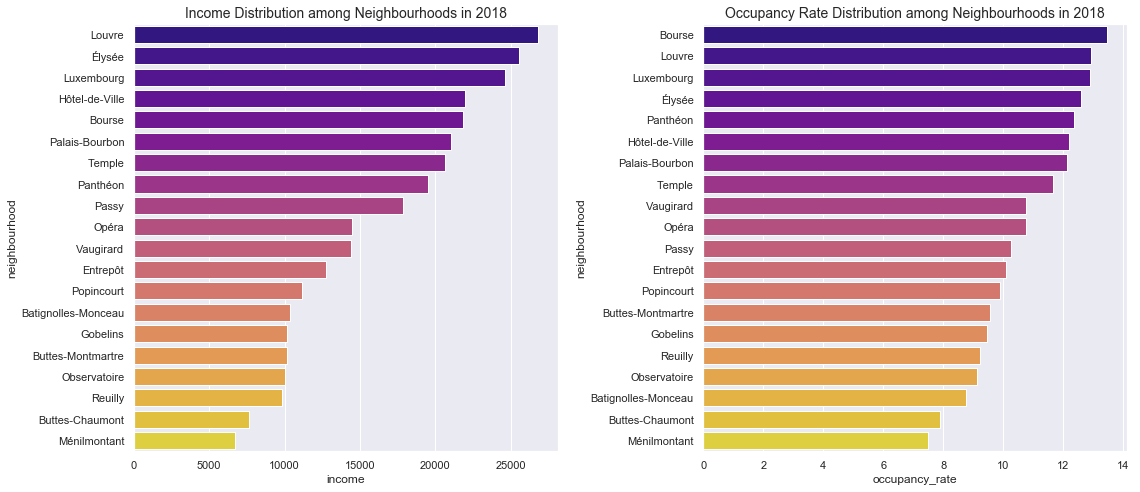

In [32]:
# how is income and occupancy rate distributed by neighbourhood.
sns.set_style('dark')
sns.set(rc={'figure.figsize':(16,7)})

# group data by neighbourhood and calculate average 
x = ent_home.groupby('neighbourhood').mean().loc[:,['income', 'occupancy_rate']].reset_index()

plt.subplot(1,2,1)
a = x.sort_values('income', ascending = False)
sns.barplot(x = 'income', y = 'neighbourhood', dodge = False, data = a, palette = 'plasma', ci = 0)
plt.title('Income Distribution among Neighbourhoods in 2018', size = 14)

plt.subplot(1,2,2)
b = x.set_index(a.index).sort_values('occupancy_rate', ascending = False)
sns.barplot(x = 'occupancy_rate', y = 'neighbourhood', dodge = False, data = b, palette = 'plasma', ci = 0)
plt.title('Occupancy Rate Distribution among Neighbourhoods in 2018', size = 14)

plt.tight_layout()
plt.show()

We can see that the most profitable neighbourhood (Louvre) differs from the most occupied one (Bourse). Although their occupancy rates are close (with Louvre taking the second place falling just under 1% behind Bourse), the income potentially generated in Louvre neighbourhood is about '$'5,000 more than in Bourse (taking the fifth place in income chart).

Let's also see where the listings with high income and high occupancy rates for 2018 are located on the map. This should provide a better visual.

I will again use folium package to illustrate the actual map of Paris and lay over it neighbourhoods and dot locations for listins in question. I will sample our dataframe twice and once I will plot points in purple for income of the first sample and in green for occupancy rate from the second sample. It should give a fairly good picture of listing locations. To be able to distinguish among different levels of income and occupancy rates I will make the sizes of the circles correlate with the corresponding values. 

I am also adding markers for five main Paris attractions that should help to better understand the map.

In [33]:
# initiate the map 
m = folium.Map(location=[48.86, 2.35], zoom_start=12)
 
# add a layer with neighbourhoods
folium.Choropleth(
 geo_data="neighbourhoods (1).geojson",
 fill_color='lightpink',
 fill_opacity=0.4,
 line_opacity=0.7
 ).add_to(m)

# sample all listings for 1000 
income = ent_home.sample(1000)

# add circles for above listings with sizes correlated to income
for i, row in income.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']], radius = row['income']/1000, 
       #popup = 'income: $' + str(row['income']),
                  color = 'purple', fill = True, fill_color = 'purple', fill_opacity = 0.6).add_to(m)

# second sample for 1000 listings
occupancy = ent_home.sample(1000)

# add circles for above listings with sizes correlated to occupancy rate
for i, row in occupancy.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']], radius = row['occupancy_rate']*2.5, 
      #  popup = 'occupancy rate: '+ str(row['occupancy_rate']),
                  color = 'green', fill = True, fill_color = 'green', fill_opacity = 0.2).add_to(m)
    
# add markers for Paris main attractions 
attractions = pd.DataFrame.from_dict({'1':[48.858093, 2.294694, 'Eiffel Tower'], 
                           '2':[48.86111, 2.33639, 'Louvre'],
                           '3':[48.852966, 2.349902, 'Notre Dame'],
                           '4': [48.873756, 2.294946, 'Arc de Triumphe'],
                           '5': [48.886452, 2.343121, 'Sacre Coeur']}, orient = 'index',
                                    columns = ['latitude', 'longitude', 'name'])

for i, row in attractions.iterrows():
    folium.Marker(location = [row['latitude'], row['longitude']], popup = row['name']).add_to(m)
    
m.fit_bounds(m.get_bounds())
m

The map above shows a sample distribution of 2000 listings across neighbourhoods. We can see that more central places that are located near main attractions. Especially Notre Dame and Sacre Coeur. While most higher income generating places follow this finding as prices in central parts tend to be higher. Interestingly, some of the most rented places are located further out and might represent a good deal that renters on AirBnB are looking for. It is definitely worth exploring what can define a good deal and therefore get apartment rented more often.

Before that let's explore what factors are influencing income. As comes from the formula we used to calculate income, it is proportional to price and occupancy rate. Price forming depends on location, size and other characteristics. Obviously, the higher price will mean the higher income. But what if the place does not get rented? Therefore, in my opinion, it is more important to look at the factors that influence occupancy rate. There are many listing features that can contribute to forming occupancy rate. Roughly they can be divided into three categories:

- apartment features (number of bedrooms, bathrooms, guests the place can accommodate, is it instant bookable etc.)
- host characteristics (is host a superhost, host response rate and time, is he near the listing location etc.)
- what people think about the listing (review ratings based on location, accuracy, communication etc.)

Let's first see how apartment characteristics influence the the occupancy rate.

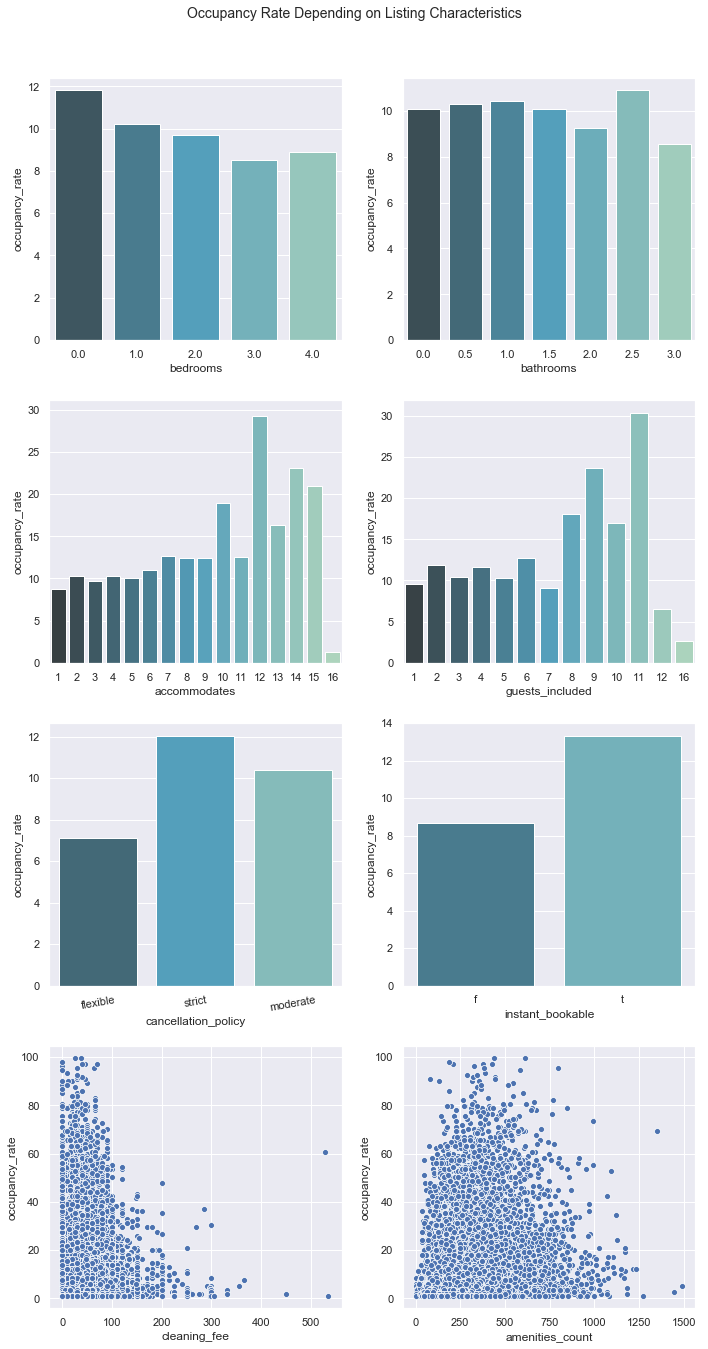

In [34]:
# create bar and scatter plots for occupancy rate with regards to each apartment characteristic in question
sns.set(rc={'figure.figsize':(10,18)})
plt.subplot(4,2,1)
sns.barplot(x = 'bedrooms', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,2)
sns.barplot(x = 'bathrooms', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,3)
sns.barplot(x = 'accommodates', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,4)
sns.barplot(x = 'guests_included', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,5)
sns.barplot(x = 'cancellation_policy', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)
plt.xticks(rotation = 10)

plt.subplot(4,2,6)
sns.barplot(x = 'instant_bookable', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,7)
sns.scatterplot(x = 'cleaning_fee', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.subplot(4,2,8)
sns.scatterplot(x = 'amenities_count', y = 'occupancy_rate', palette = 'GnBu_d', data = ent_home, ci = 0)

plt.suptitle('Occupancy Rate Depending on Listing Characteristics', size = 14, y = 1.04)
plt.tight_layout()

plt.show()

There are some interesting findings from above graphs:
- apartments of all sizes (number of bedrooms and bathrooms) are being rented approximately equaly (around 10% occupancy rate - which is an average occupancy rate across all listings). This fact might be supported by assumption that people travel in groups of different sizes and everybody is able to find a place to stay matching their needs. For more detailed analysis it is reasonable to look at the listings in groups divided by size;
- however, places that can accommodate more guests regardless of their size are getting rented more often. 
- it is suprising that the places with stricter cancellation policy are being rented more often. It might be  due to the fact that with stricter cancellation policy it is more difficult to make changes to travel plans;
- similar understanding can be behind the finding that places that are instant bookable (no pre-approval from host to rent the place is needed) have higher occupancy rates. Also the fact that people tend to minimize human interactions can contribute to this outcome;
- there is no definite correlation between occupancy rate and cleaning fee. But in general people tend to stay in places with reasonably priced cleaning fees;
- the number of amenities offered by each place definitely effects occupancy rate. While there is no need in excessive amout of amenties, the travelers prefer the places with them more than without. For further analysis it is valuable to take a closer look what amenities in particular influence occupancy rate.

Overall it looks like the features of the listing itself have a big impact on forming the occupancy rate. These features are coming with the apartment as well as its location that also influences if the place gets rented. If the place is not located near main attractions or is not very large, what can the host do to increase the probability of renting out his or her place? Let's now see if not only the place itself matters by trying to find links between estimated occupancy rate and host characteristics.

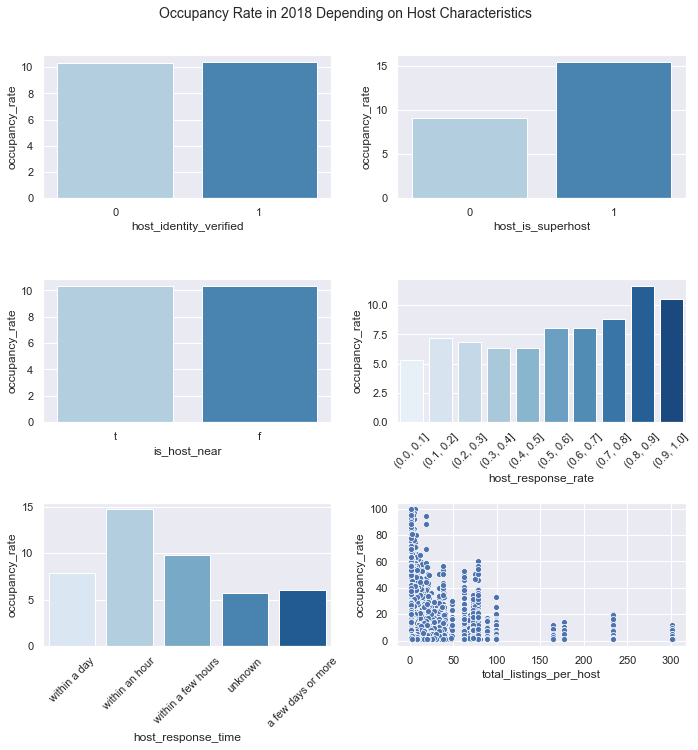

In [35]:
# create bar and scatter plots for occupancy rate with regards to each host characteristic in question
sns.set(rc={'figure.figsize':(10,10)})

plt.subplot(3,2,1)
sns.barplot(x = 'host_identity_verified', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,2)
sns.barplot(x = 'host_is_superhost', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,3)
sns.barplot(x = 'is_host_near', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,4)
a = ent_home.groupby(pd.cut(ent_home['host_response_rate'], np.arange(0, 1.01, 0.10))).mean().loc[:,['occupancy_rate', 'price']].reset_index()
sns.barplot(x = 'host_response_rate', y = 'occupancy_rate', palette = 'Blues', ci = 0, data = a)
plt.xticks(rotation = 45)

plt.subplot(3,2,5)
sns.barplot(x = 'host_response_time', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)
plt.xticks(rotation = 45)

plt.subplot(3,2,6)
sns.scatterplot(x = 'total_listings_per_host', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.suptitle('Occupancy Rate in 2018 Depending on Host Characteristics', size = 14, y = 1.04)
plt.tight_layout()

plt.show()

Some core conclusions from above graphs:
- it is beneficial to be a superhost as you place will be rented on average 6% more often
- it is important to answer to as many queries as possible and do it promptly: hosts that answer within an hour have on average 5% higher occupancy rates
- identified host identity and host proximity to the listing don't seem to matter and might need further exploration
- the most occupied places belong to hosts with fewer listings as it might get difficult to provide good services if need to manage over 100 listings. For further exploration it might be interesting to look at 4 hosts that have over 100 listings each.

Another important group of characteristics is the one containing people opinions - reviews. Let's see how reviews for different categories influence occupancy rate.

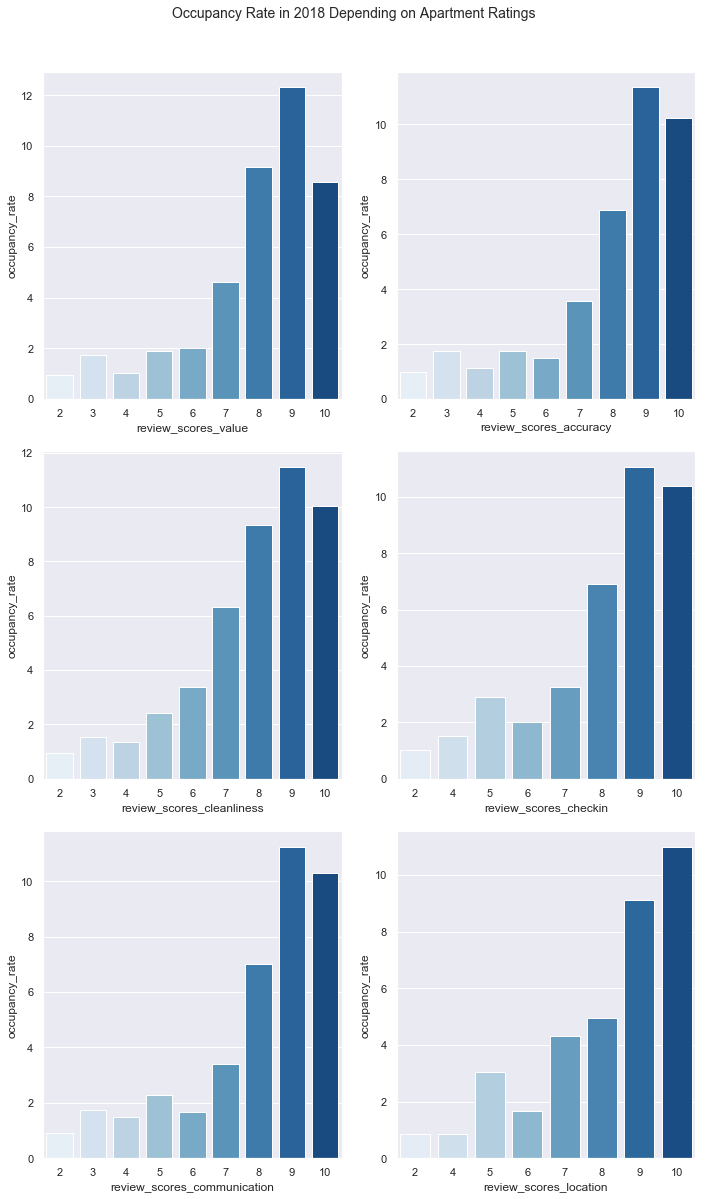

In [36]:
# create bar and scatter plots for occupancy rate with regards to each host characteristic in question
sns.set(rc={'figure.figsize':(10,16)})

plt.subplot(3,2,1)
sns.barplot(x = 'review_scores_value', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,2)
sns.barplot(x = 'review_scores_accuracy', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,3)
sns.barplot(x = 'review_scores_cleanliness', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,4)
sns.barplot(x = 'review_scores_checkin', y = 'occupancy_rate', palette = 'Blues', ci = 0, data = ent_home)

plt.subplot(3,2,5)
sns.barplot(x = 'review_scores_communication', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.subplot(3,2,6)
sns.barplot(x = 'review_scores_location', y = 'occupancy_rate', palette = 'Blues', data = ent_home, ci = 0)

plt.suptitle('Occupancy Rate in 2018 Depending on Apartment Ratings', size = 14, y = 1.04)
plt.tight_layout()

plt.show()

It is very clear from above graphs that reviews are important and places with ratings 9 and higher are being rented more often. Especially it is visible in categories accuracy (how realistic internet representation is), check-in (comfort of initial access) and location. 

We have seen previously seen on the map that apartments with higher income have usually more centered location, while high occupancy rate does not necessary mean the place is in the center. As above findings specify, occupancy rate is highly correlated with the ratings people give to different apartment characteristics. High ratings lead to more bookings. This means that previously booked place can be rented again and again if people are satisfied with it.

It will be interesting to see how these ratings differ across neighbourhoods. I will show this on six small maps with choropleth maps for six ratings in different categories plotted with geopandas and on one large map with overall rating score with folium.

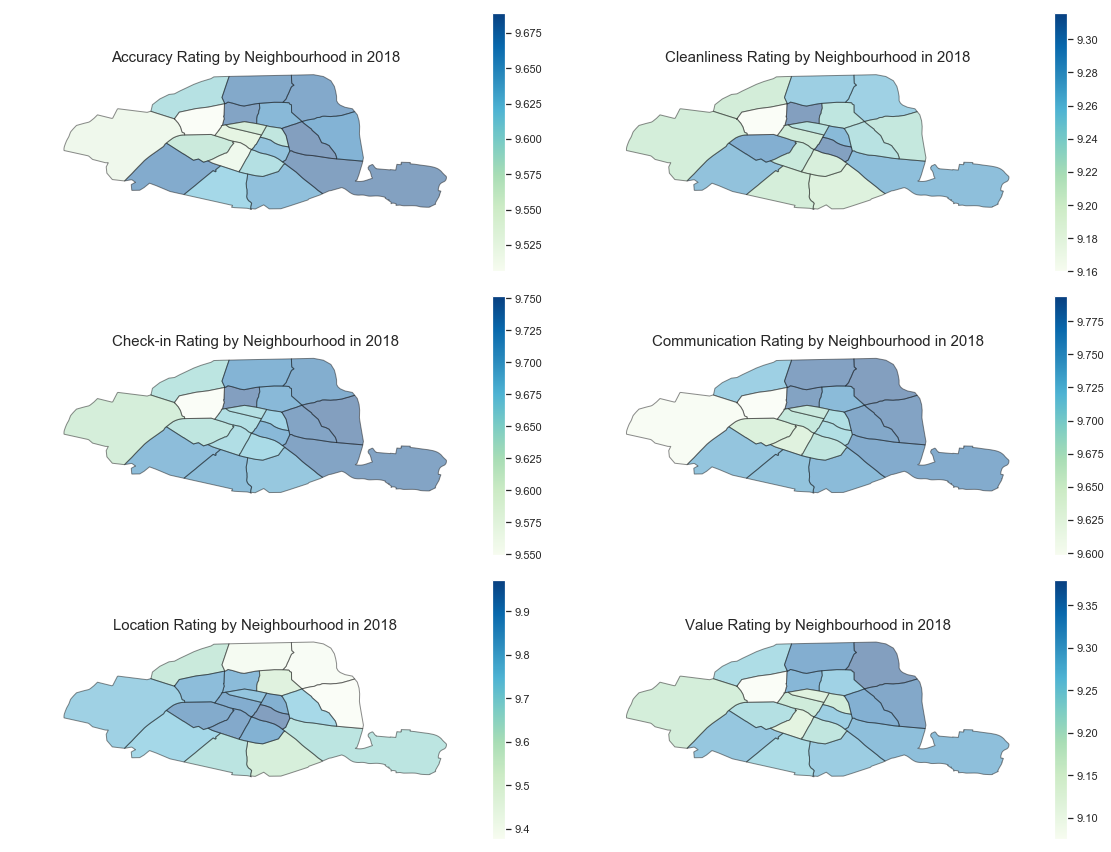

In [38]:
# load neighbourhoods map
n_df = geopandas.read_file("neighbourhoods (1).geojson")

# join it with the average values accross neighbourhoods for listings in question
a = ent_home.groupby('neighbourhood').mean()
join = n_df.set_index('neighbourhood').join(a)

# plot results on 6 subplots - one for each rating score category
fig, ax = plt.subplots(3,2, figsize=(16, 12))

ax[0][0].title.set_text('Accuracy Rating by Neighbourhood in 2018')
ax[0][0].title.set_size(15)
ax[0][0].axis('off')
join.plot(column = 'review_scores_accuracy', ax = ax[0][0], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

ax[0][1].title.set_text('Cleanliness Rating by Neighbourhood in 2018')
ax[0][1].title.set_size(15)
ax[0][1].axis('off')
join.plot(column = 'review_scores_cleanliness', ax = ax[0][1], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

ax[1][0].title.set_text('Check-in Rating by Neighbourhood in 2018')
ax[1][0].title.set_size(15)
ax[1][0].axis('off')
join.plot(column = 'review_scores_checkin', ax = ax[1][0], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

ax[1][1].title.set_text('Communication Rating by Neighbourhood in 2018')
ax[1][1].title.set_size(15)
ax[1][1].axis('off')
join.plot(column = 'review_scores_communication', ax = ax[1][1], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

ax[2][0].title.set_text('Location Rating by Neighbourhood in 2018')
ax[2][0].title.set_size(15)
ax[2][0].axis('off')
join.plot(column = 'review_scores_location', ax = ax[2][0], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

ax[2][1].title.set_text('Value Rating by Neighbourhood in 2018')
ax[2][1].title.set_size(15)
ax[2][1].axis('off')
join.plot(column = 'review_scores_value', ax = ax[2][1], alpha=0.5, edgecolor='k', cmap = 'GnBu', legend = True)

plt.tight_layout()
plt.show()

In [39]:
# plot overall review scores over actual map
m = folium.Map(location=[48.86, 2.35], zoom_start=12)
a = ent_home.groupby('neighbourhood').mean().reset_index()

#because of accents in french names, data in geojson neighbourhood names does not match the one in our dataset. 
#changing names in dataset as a quick fix
names = {'Entrepôt': 'EntrepÃ´t', 'Ménilmontant': 'MÃ©nilmontant', 'Opéra': 'OpÃ©ra', 'Panthéon': 'PanthÃ©on', 
         'Hôtel-de-Ville': 'HÃ´tel-de-Ville', 'Élysée': 'Ã‰lysÃ©e'}
a.neighbourhood.replace(names, inplace = True)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data="neighbourhoods (1).geojson",
 name='choropleth',
 data=a,
 columns=('neighbourhood','review_scores_rating'),
 key_on='feature.properties.neighbourhood',
 fill_color='GnBu',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Review rating'
).add_to(m)

folium.LayerControl().add_to(m)
m

All of the neighbourhoods have ratings above 9 (or 90 for overall rating). However, the central parts tend to have smaller ratings (except for location category). It is a very interesting finding that opens up a new reason for exploration. Looking deeper into what people think about each place and their experience in it and with the host can help identify more characteristics that help to get the place rented. Typically, travelers renting through AirBnB are looking for a good deal. What are the componets of a good deal and how to know that you are getting it? So far I have found out some factors that effect occupancy rate:
- possibility to accommodate larger groups
- ability to rent the place right away without host's approval
- appropriate amount of amenities
- fast and clear communication with host
- getting a place from superhost
- location of the place
- experiences of previous renters.

Further I will try to classify listings in terms "does the place represent a good deal or not" and see if I can predict whether a listing is a good one.